In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *

(array([0, 1]), array([0, 1]))

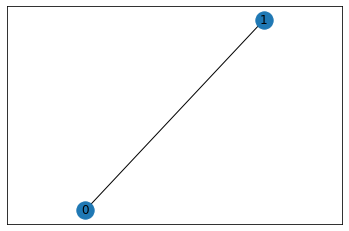

In [2]:
V = np.arange(0,2,1)
E =[(0,1,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)
np.array(list(G.nodes)), V

In [3]:
def createCircuit(x,G,depth):
    V = list(G.nodes)
    num_V = len(V)
    q = QuantumRegister(num_V)
    c = ClassicalRegister(num_V)
    circ = QuantumCircuit(q,c)
    circ.h(range(num_V))
    circ.barrier()
    for d in range(depth):
        gamma=x[2*d]
        beta=x[2*d+1]
        for edge in G.edges():
            i=int(edge[0])
            j=int(edge[1])
            w = G[i][j]['weight']
            circ.cx(q[i],q[j])
            circ.rz(w*gamma,q[j])
            circ.cx(q[i],q[j])
        circ.barrier()
        circ.rx(2*beta,range(num_V))
        circ.barrier()
    circ.measure(q,c)
    return circ

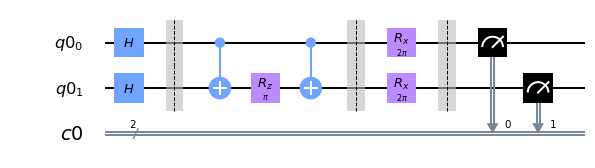

In [4]:
createCircuit(np.array((np.pi,np.pi)),G,1).draw(output='mpl')

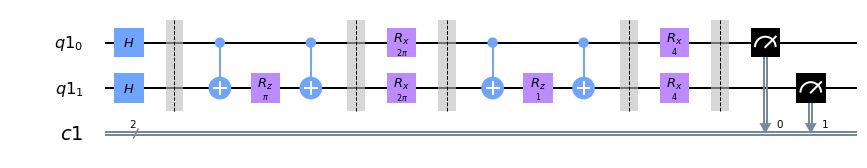

In [5]:
createCircuit(np.array((np.pi,np.pi,1,2)),G,2).draw(output='mpl')

In [6]:
def cost(x,G):
    C=0
    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])
        w = G[i][j]['weight']
        C = C + w/2*(1-(2*x[i]-1)*(2*x[j]-1))
    return C

In [7]:
def listcosts(G):
    costs={}
    maximum=0
    solutions=[]
    V = list(G.nodes)
    num_V = len(V)
    for i in range(2**num_V):
        binstring="{0:b}".format(i).zfill(num_V)
        y=[int(i) for i in binstring]
        costs[binstring]=cost(y,G)
        maximum = max(maximum,costs[binstring])
    for key in costs:
        if costs[key]==maximum:
            solutions.append(key)
    return costs, maximum, solutions

In [8]:
listcosts(G)

({'00': 0.0, '01': 1.0, '10': 1.0, '11': 0.0}, 1.0, ['01', '10'])

In [9]:
def expectationValue(data,G):
    E=[]
    V = list(G.nodes)
    num_qubits = len(V)
    for item in range(0,len(data.results)):
        shots = data.results[item].shots
        counts = data.results[item].data.counts
        E.append(0)
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            binstring="{0:b}".format(int(key,0)).zfill(num_qubits)
            y=[int(i) for i in binstring]
            E[item] += cost(y,G)*c/shots
    return E

Simulate the circuit

In [10]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [11]:
circuits=[]
n=16
for gamma in np.linspace(0,np.pi/2,n):
    for beta in np.linspace(0,np.pi/2,n):
        circuits.append(createCircuit(np.array((gamma,beta)),G,1))

In [12]:
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)

In [13]:
val=expectationValue(job_sim.result(),G)

0.99658203125

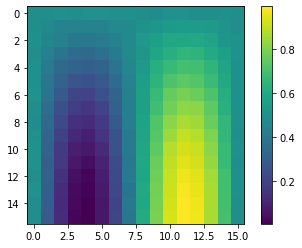

In [14]:
pl.imshow(np.array(val).reshape(n,n))
pl.colorbar()
np.max(val)

In [15]:
from scipy import optimize as opt

In [16]:
def getval(x, backend, noisemodel=None):
    j = execute(createCircuit(x,G,1), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=expectationValue(j.result(),G)
    return -val[0]

In [17]:
out=opt.minimize(getval, x0=(1, 1), method='Nelder-Mead',\
                 args=(backend_sim,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 21
         Function evaluations: 42


In [18]:
out.x

array([1.57497864, 1.1747406 ])

In [19]:
j = execute(createCircuit(out.x,G,1), backend_sim, shots=1024*2*2*2)

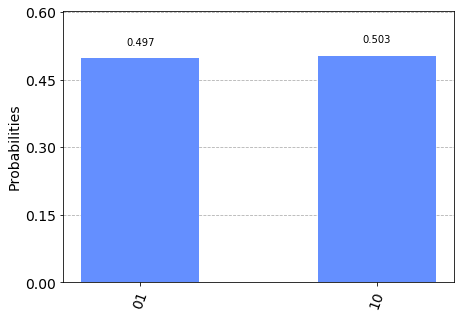

In [20]:
plot_histogram(j.result().get_counts())

In [21]:
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [22]:
backendnameibm = 'ibmqx2'
backendibm = provider.get_backend(backendnameibm)

In [23]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model

properties = backendibm.properties()
ibmqx2noisemodel = basic_device_noise_model(properties)

In [24]:
job_sim_noise = execute(circuits, backend_sim, noise_model=ibmqx2noisemodel, shots=1024*2*2*2)

In [25]:
val_noise=expectationValue(job_sim_noise.result(),G)

0.955322265625

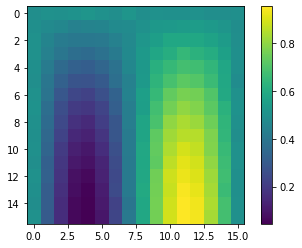

In [26]:
pl.imshow(np.array(val_noise).reshape(n,n))
pl.colorbar()
np.max(val_noise)

In [27]:
out_noise=opt.minimize(getval, x0=(1,1),\
                       args=(backend_sim,ibmqx2noisemodel), method='Nelder-Mead',\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.959229
         Iterations: 21
         Function evaluations: 47


In [28]:
j = execute(createCircuit(out_noise.x,G,1), backend_sim, shots=1024*2*2*2)

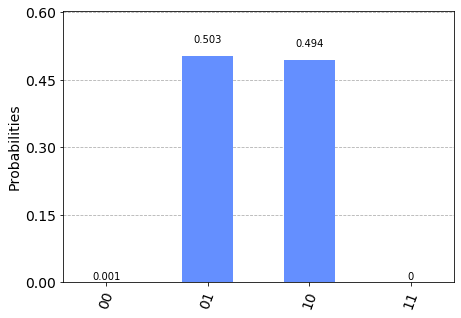

In [29]:
plot_histogram(j.result().get_counts())

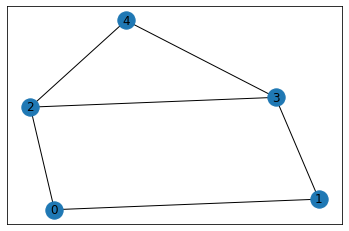

In [30]:
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,1.0),(2,3,1.0),(3,1,1.0),(3,4,1.0),(4,2,1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)

In [31]:
l,m,maxcost=listcosts(G)
print(m,maxcost)

5.0 ['01100', '01101', '10010', '10011']


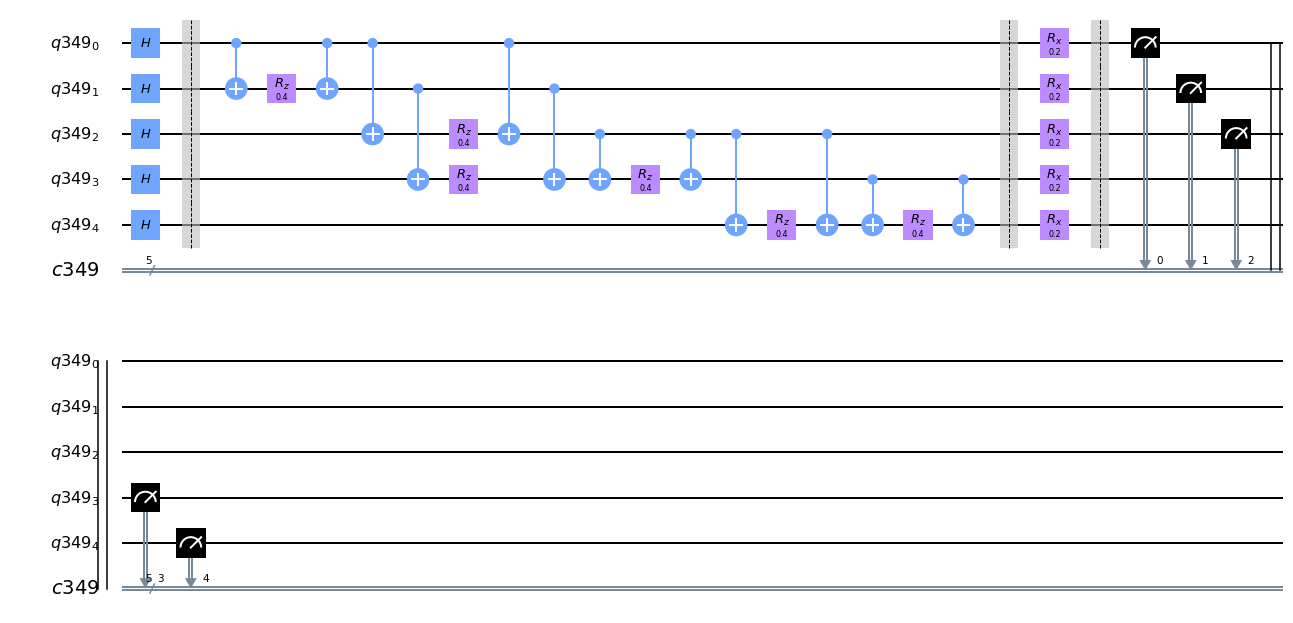

In [32]:
createCircuit(np.array((0.4,0.1)),G,1).draw(output='mpl')

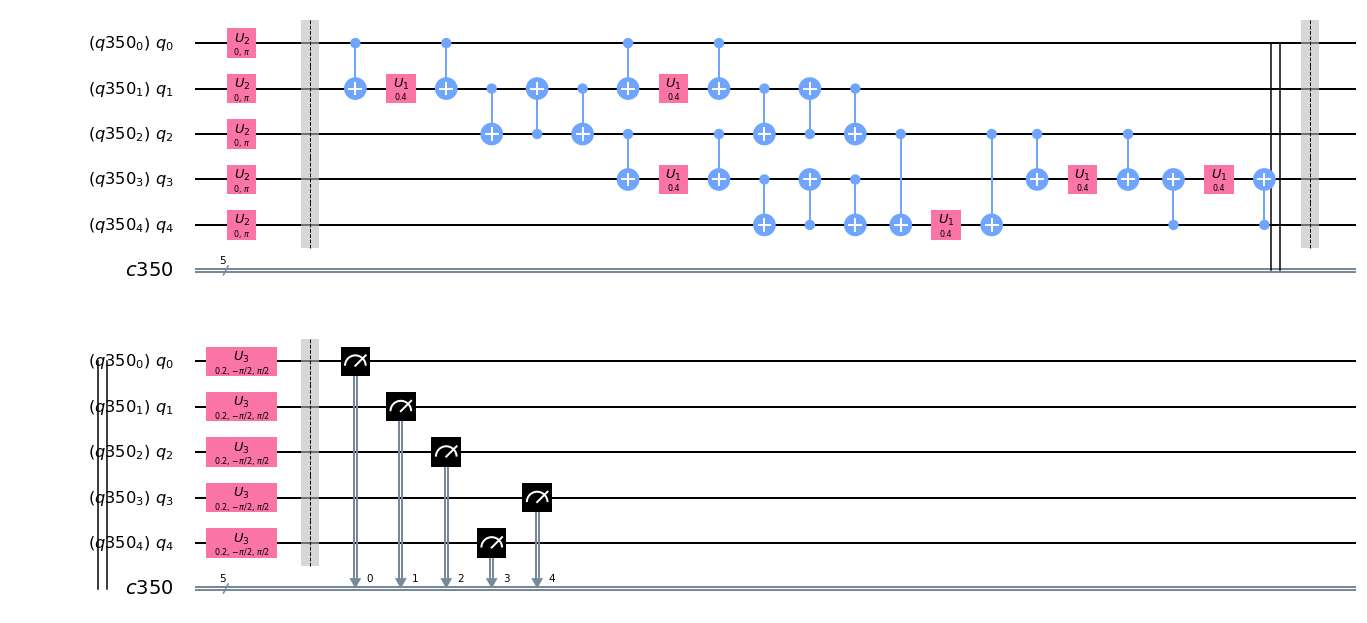

In [33]:
transpile(createCircuit(np.array((0.4,0.1)),G,1),backend=backendibm).draw(output='mpl')

In [34]:
circuitsp1=[]
n=8
for gamma in np.linspace(0,np.pi/2,n):
    for beta in np.linspace(0,np.pi/2,n):
        circuitsp1.append(createCircuit(np.array((gamma,beta)),G,1))
circuitsp2=[]
n=8
for gamma in np.linspace(0,np.pi/2,n):
    for beta in np.linspace(0,np.pi/2,n):
        for gamma2 in np.linspace(0,np.pi/2,n):
            for beta2 in np.linspace(0,np.pi/2,n):
                circuitsp2.append(createCircuit(np.array((gamma,beta,gamma2,beta2)),G,2))

In [43]:
job_simp1 = execute(circuitsp1, backend_sim, shots=1024*2*2*2)

3.7784423828125

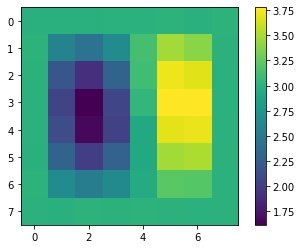

In [44]:
val=expectationValue(job_simp1.result(),G)
pl.imshow(np.array(val).reshape(n,n))
pl.colorbar()
np.max(val)

In [45]:
job_simp2 = execute(circuitsp2, backend_sim, shots=1024*2*2*2)

In [49]:
val=expectationValue(job_simp2.result(),G)
np.max(val)

4.09130859375

In [50]:
def getval(x, backend, noisemodel=None):
    j = execute(createCircuit(x,G,1), backend, shots=1024*2*2*2*2)
    val=expectationValue(j.result(),G)
    return -val[0]

In [51]:
out=opt.minimize(getval, x0=(1, 1), method='Nelder-Mead',\
                 args=(backend_sim,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -3.903015
         Iterations: 17
         Function evaluations: 40


In [52]:
out.x

array([0.67109375, 1.2171875 ])

In [53]:
j = execute(createCircuit(out.x,G,1), backend_sim, shots=1024*2*2*2)

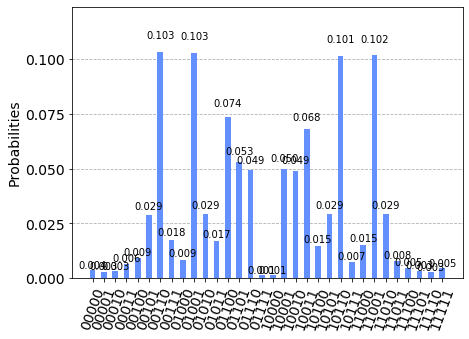

In [54]:
plot_histogram(j.result().get_counts())

In [55]:
expectationValue(j.result(),G)

[3.9129638671875]

In [59]:
cost((0,0,1,1,0),G), cost((0,1,0,0,1),G)

(4.0, 4.0)